# How to add cross-thread persistence to your graph

By default, LangGraph state is scoped to a single thread. LangGraph also allows you to store information that can be **shared** across threads.

For instance, you can persist each user’s preferences to a shared memory and reuse them in new conversational threads.

In this guide, we will show how to construct and use a graph that has a shared memory implemented using the `Store` interface.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
    Support for the <code>Store</code> API that is used in this notebook was added in LangGraph <code>v0.2.32</code>.
    </p>
</div>

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Create graph

In this example we will create a graph that will let us store information about a user's preferences. We will do so by defining an `InMemoryStore` - an object that can store data in memory and query that data. We can then pass the store object when compiling the graph. This allows each node in the graph to access the store: when you define node functions, you can define `store` keyword argument, and LangGraph will automatically pass the store object you compiled the graph with.

When storing objects using the `Store` interface you define two things:

* the namespace for the object, a tuple (similar to directories)
* the object key (similar to filenames)

In our example, we'll be using `("memories", <user_id>)` as namespace and random UUID as key for each new memory.

Importantly, to determine the user, we will be passing `user_id` via the config keyword argument of each node function.

In [3]:
from typing import Literal, TypedDict, Annotated
import uuid
from langchain_openai import ChatOpenAI

from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver


# We will give this as a tool to the agent
# This will let the agent call this tool to save a fact
class Info(TypedDict):
    """This tool should be called when you want to save a new fact about the user.

    Attributes:
        fact (str): A fact about the user.
        topic (str): The topic related the fact is about, i.e. Food, Location, Movies, etc.
    """

    fact: str
    topic: str


# This is the prompt we give the agent
# We will pass known info into the prompt
# We will tell it to use the Info tool to save more
prompt = """You are a helpful assistant that learns about users to provide better assistance.

Current user information:
<info>
{info}
</info>

Instructions:
1. Use the `Info` tool to save new information the user shares.
2. Save facts, opinions, preferences, and experiences.
3. Your goal: Improve assistance by building a user profile over time.

Remember: Every piece of information helps you serve the user better in future interactions.
"""


# We give the model access to the Info tool
model = ChatOpenAI(model="gpt-4o-mini").bind_tools([Info])


def call_model(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    """Call the model."""
    user_id = config["configurable"]["user_id"]
    memories = store.search(("memories", user_id))
    info = "\n".join([d.value["fact"] for d in memories])
    # Format system prompt
    system_msg = prompt.format(info=info)
    # Call model
    response = model.invoke(
        [{"role": "system", "content": system_msg}] + state["messages"]
    )
    return {"messages": [response]}


# Routing function to decide what to do next
# If no tool calls, then we end
# If tool calls, then we update memory
def route(state):
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "update_memory"


def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    """Update the memory."""
    user_id = config["configurable"]["user_id"]
    memory_id = str(uuid.uuid4())
    tool_calls = []
    memories = {}
    # Each tool call is a new memory to save
    for tc in state["messages"][-1].tool_calls:
        # We append ToolMessages (to pass back to the LLM)
        # This is needed because OpenAI requires each tool call be followed by a ToolMessage
        tool_calls.append(
            {"role": "tool", "content": "Saved!", "tool_call_id": tc["id"]}
        )
        # We create a new memory from this tool call
        store.put(
            ("memories", user_id),
            memory_id,
            {
                "fact": tc["args"]["fact"],
                "topic": tc["args"]["topic"],
            },
        )
    # Return the messages and memories to update the state with
    return {"messages": tool_calls}


# This is the in memory checkpointer we will use
# We need this because we want to enable threads (conversations)
checkpointer = MemorySaver()

# This is the in memory store needed to save the memories (i.e. user preferences)
in_memory_store = InMemoryStore()

# Construct this relatively simple graph
graph = StateGraph(MessagesState)
graph.add_node(call_model)
graph.add_node(update_memory)
graph.add_edge("update_memory", END)
graph.add_edge(START, "call_model")
graph.add_conditional_edges("call_model", route, path_map=[END, "update_memory"])
graph = graph.compile(checkpointer=checkpointer, store=in_memory_store)

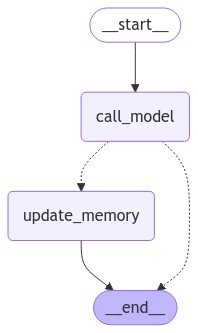

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Run graph on one thread

We can now run the graph on one thread and give it some information

In [4]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# First let's just say hi to the AI
for update in graph.stream(
    {"messages": [{"role": "user", "content": "hi"}]}, config, stream_mode="updates"
):
    print(update)

# Let's continue the conversation (by passing the same config) and tell the AI we like pepperoni pizza
for update in graph.stream(
    {"messages": [{"role": "user", "content": "i like pepperoni pizza"}]},
    config,
    stream_mode="updates",
):
    print(update)

# Let's continue the conversation even further (by passing the same config) and tell the AI we live in SF
for update in graph.stream(
    {"messages": [{"role": "user", "content": "i also just moved to SF"}]},
    config,
    stream_mode="updates",
):
    print(update)

{'call_model': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 178, 'total_tokens': 188, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_74ba47b4ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-8e7b57b7-8231-4811-945d-a2cf2e1adba3-0', usage_metadata={'input_tokens': 178, 'output_tokens': 10, 'total_tokens': 188})]}}
{'call_model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mpPvip6DbMYkZueShwDDws3y', 'function': {'arguments': '{"fact":"User likes pepperoni pizza","topic":"Food"}', 'name': 'Info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 200, 'total_tokens': 221, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'sy

We can now inspect our in-memory store and verify that we have in fact saved the memories for the user:

In [5]:
for memory in in_memory_store.search(("memories", "1")):
    print(memory.value)

{'fact': 'User likes pepperoni pizza', 'topic': 'Food'}
{'fact': 'User just moved to San Francisco', 'topic': 'Location'}


## Run graph on a different thread

We can now run the graph on a different thread and see that it remembers facts about the user (specifically that the user likes pepperoni pizza and lives in SF):

In [6]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

for update in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "where and what should i eat for dinner? Can you list some restaurants?",
            }
        ]
    },
    config,
    stream_mode="updates",
):
    print(update)

{'call_model': {'messages': [AIMessage(content="Since you like pepperoni pizza, I can recommend a few places in San Francisco where you can enjoy some delicious pizza. Here are some options:\n\n1. **Tony's Pizza Napoletana** - Located in North Beach, this restaurant is famous for its award-winning pizzas. You can find a variety of styles, including classic pepperoni.\n\n2. **Pizza Orgasmica** - Known for its fun atmosphere and a wide range of pizza options, including pepperoni, this spot is a local favorite.\n\n3. **Little Star Pizza** - This place offers deep-dish and thin-crust options. Their pepperoni pizza is highly recommended.\n\n4. **Pizzeria Delfina** - A popular spot known for its artisanal pizzas, including a delicious pepperoni option.\n\n5. **The Pizza Place on Noriega** - A casual eatery offering classic pizza options in the Sunset District.\n\nWould you like more options, or are you interested in a specific neighborhood for dinner?", additional_kwargs={'refusal': None}, r

Perfect! The AI recommended restaurants in SF, and included a pizza restaurant at the top of it's list.

Notice that the `messages` in this new thread do NOT contain the messages from the previous thread since we didn't store them as shared values across the `user_id`. However, the `info` we saved in the previous thread was saved since we passed in the same `user_id` in this new thread.

Let's now run the graph for another user to verify that the preferences of the first user are self contained:

In [7]:
config = {"configurable": {"thread_id": "3", "user_id": "2"}}

for update in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "where and what should i eat for dinner? Can you list some restaurants?",
            }
        ]
    },
    config,
    stream_mode="updates",
):
    print(update)

{'call_model': {'messages': [AIMessage(content="To help you better, could you please share your location or the area you're interested in? Additionally, do you have any preferences for cuisine or dietary restrictions?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 192, 'total_tokens': 224, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_74ba47b4ac', 'finish_reason': 'stop', 'logprobs': None}, id='run-fba82c81-703a-4f5e-bd1a-1edf5876425e-0', usage_metadata={'input_tokens': 192, 'output_tokens': 32, 'total_tokens': 224})]}}


Perfect! The graph has forgotten all of the previous preferences and has to ask the user for it's location and dietary preferences.

We can also verify that there are no memories stored for user "2":

In [8]:
in_memory_store.search(("memories", "2"))

[]